# Thrones2Vec

© Yuriy Guts, 2016

Using only the raw text of [A Song of Ice and Fire](https://en.wikipedia.org/wiki/A_Song_of_Ice_and_Fire), we'll derive and explore the semantic properties of its words.

## Imports

In [1]:
from __future__ import absolute_import, division, print_function

In [2]:
import codecs
import glob
import logging
import multiprocessing
import os
import pprint
import re

In [3]:
import nltk
import gensim.models.word2vec as w2v
import sklearn.manifold
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

C:\Users\smilemango\Anaconda3\envs\py35\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


**Set up logging**

In [5]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

**Download NLTK tokenizer models (only the first time)**

In [6]:
nltk.download("punkt")
nltk.download("stopwords")

removing collection member with no package: panlex_lite
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\smilemango\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\smilemango\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Prepare Corpus

**Load books from files**

In [7]:
book_filenames = sorted(glob.glob("data/*1.txt"))

In [8]:
print("Found books:")
book_filenames

Found books:


['data\\got1.txt']

**Combine the books into one string**

In [9]:
corpus_raw = u""
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus_raw += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()

Reading 'data\got1.txt'...
Corpus is now 1787941 characters long



**Split the corpus into sentences**

In [10]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [11]:
raw_sentences = tokenizer.tokenize(corpus_raw)

In [12]:
#convert into a list of words
#rtemove unnnecessary,, split into words, no hyphens
#list of words
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [13]:
#sentence where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [14]:
print(raw_sentences[5])
print(sentence_to_wordlist(raw_sentences[5]))

Heraldic crest by Virginia Norey.
['Heraldic', 'crest', 'by', 'Virginia', 'Norey']


In [15]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 331,572 tokens


## Train Word2Vec

In [16]:
#ONCE we have vectors
#step 3 - build model
#3 main tasks that vectors help with
#DISTANCE, SIMILARITY, RANKING

# Dimensionality of the resulting word vectors.
#more dimensions, more computationally expensive to train
#but also more accurate
#more dimensions = more generalized
num_features = 300
# Minimum word count threshold.
min_word_count = 3

# Number of threads to run in parallel.
#more workers, faster we train
num_workers = multiprocessing.cpu_count()

# Context window length.
context_size = 7

# Downsample setting for frequent words.
#0 - 1e-5 is good for this
downsampling = 1e-3

# Seed for the RNG, to make the results reproducible.
#random number generator
#deterministic, good for debugging
seed = 1

In [17]:
thrones2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [18]:
thrones2vec.build_vocab(sentences)

2017-05-10 18:46:28,039 : INFO : collecting all words and their counts
2017-05-10 18:46:28,041 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2017-05-10 18:46:28,081 : INFO : PROGRESS: at sentence #10000, processed 140984 words, keeping 10280 word types
2017-05-10 18:46:28,119 : INFO : PROGRESS: at sentence #20000, processed 279730 words, keeping 13558 word types
2017-05-10 18:46:28,134 : INFO : collected 15178 word types from a corpus of 331572 raw words and 23532 sentences
2017-05-10 18:46:28,136 : INFO : Loading a fresh vocabulary
2017-05-10 18:46:28,169 : INFO : min_count=3 retains 7234 unique words (47% of original 15178, drops 7944)
2017-05-10 18:46:28,170 : INFO : min_count=3 leaves 321389 word corpus (96% of original 331572, drops 10183)
2017-05-10 18:46:28,197 : INFO : deleting the raw counts dictionary of 15178 items
2017-05-10 18:46:28,198 : INFO : sample=0.001 downsamples 50 most-common words
2017-05-10 18:46:28,200 : INFO : downsampling leaves e

In [19]:
print("Word2Vec vocabulary length:", len(thrones2vec.wv.vocab))

Word2Vec vocabulary length: 7234


**Start training, this might take a minute or two...**

In [20]:
thrones2vec.train(sentences,total_examples=thrones2vec.corpus_count, epochs=thrones2vec.iter)

2017-05-10 18:46:34,438 : INFO : training model with 4 workers on 7234 vocabulary and 300 features, using sg=1 hs=0 sample=0.001 negative=5 window=7
2017-05-10 18:46:35,478 : INFO : PROGRESS: at 16.49% examples, 200627 words/s, in_qsize 8, out_qsize 0
2017-05-10 18:46:36,530 : INFO : PROGRESS: at 33.71% examples, 203089 words/s, in_qsize 7, out_qsize 0
2017-05-10 18:46:37,563 : INFO : PROGRESS: at 52.30% examples, 210086 words/s, in_qsize 7, out_qsize 0
2017-05-10 18:46:38,564 : INFO : PROGRESS: at 69.74% examples, 211496 words/s, in_qsize 7, out_qsize 0
2017-05-10 18:46:39,621 : INFO : PROGRESS: at 87.85% examples, 211583 words/s, in_qsize 7, out_qsize 0
2017-05-10 18:46:40,165 : INFO : worker thread finished; awaiting finish of 3 more threads
2017-05-10 18:46:40,241 : INFO : worker thread finished; awaiting finish of 2 more threads
2017-05-10 18:46:40,258 : INFO : worker thread finished; awaiting finish of 1 more threads
2017-05-10 18:46:40,277 : INFO : worker thread finished; awaiti

1239489

**Save to file, can be useful later**

In [21]:
if not os.path.exists("trained"):
    os.makedirs("trained")

In [22]:
thrones2vec.save(os.path.join("trained", "thrones2vec.w2v"))

2017-05-10 18:46:47,567 : INFO : saving Word2Vec object under trained\thrones2vec.w2v, separately None
2017-05-10 18:46:47,572 : INFO : not storing attribute syn0norm
2017-05-10 18:46:47,575 : INFO : not storing attribute cum_table
2017-05-10 18:46:47,778 : INFO : saved trained\thrones2vec.w2v


## Explore the trained model.

In [23]:
thrones2vec = w2v.Word2Vec.load(os.path.join("trained", "thrones2vec.w2v"))

2017-05-10 18:46:49,011 : INFO : loading Word2Vec object from trained\thrones2vec.w2v
2017-05-10 18:46:49,166 : INFO : loading wv recursively from trained\thrones2vec.w2v.wv.* with mmap=None
2017-05-10 18:46:49,167 : INFO : setting ignored attribute syn0norm to None
2017-05-10 18:46:49,168 : INFO : setting ignored attribute cum_table to None
2017-05-10 18:46:49,170 : INFO : loaded trained\thrones2vec.w2v


### Compress the word vectors into 2D space and plot them

In [24]:
#my video - how to visualize a dataset easily
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [25]:
all_word_vectors_matrix = thrones2vec.wv.syn0

In [42]:
thrones2vec.wv.syn0[0]

array([  7.11405650e-02,  -1.83928475e-01,   6.84280768e-02,
        -2.55666137e-01,   4.52642590e-02,   1.29514989e-02,
        -1.54667512e-01,   2.18364596e-01,  -9.35007706e-02,
         2.75443811e-02,   2.06857957e-02,   4.02094014e-02,
         2.45789587e-02,   6.30629435e-03,   1.79098677e-02,
         7.30075166e-02,   1.36487111e-01,   2.12431565e-01,
        -1.19815230e-01,  -1.74916506e-01,   1.18759446e-01,
         4.04095575e-02,  -1.01211570e-01,   6.79972917e-02,
        -4.25461680e-02,  -7.26482645e-02,  -1.83613710e-02,
         1.02282055e-01,   1.35209695e-01,  -1.80514436e-02,
         1.88521549e-01,  -5.58337830e-02,  -1.43269345e-01,
         1.33671924e-01,   9.89941880e-02,   6.43686205e-02,
         8.06169212e-02,   1.68466479e-01,  -5.71723506e-02,
        -2.97042392e-02,   2.95767576e-01,  -4.42928001e-02,
         2.58721467e-02,  -7.46648163e-02,   2.17021957e-01,
         1.23588659e-01,  -1.66369274e-01,   1.68144211e-01,
        -1.82032675e-01,

**Train t-SNE, this could take a minute or two...**

In [26]:
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

**Plot the big picture**

In [27]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[thrones2vec.wv.vocab[word].index])
            for word in thrones2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [28]:
points.head(10)

,word,x,y
0,swallowed,7.764829,2.525259
1,moss,8.820837,2.283900
2,moved,-3.195640,4.597131
3,pit,6.749162,-4.616705
4,heavens,4.195566,-8.827318
5,halfwit,7.996840,-6.440573
6,Look,-8.513133,3.032372
7,Eyrie,-9.171520,1.098127
8,crashing,7.528110,3.065481
9,scrawled,3.995226,-1.083134


In [29]:
sns.set_context("poster")

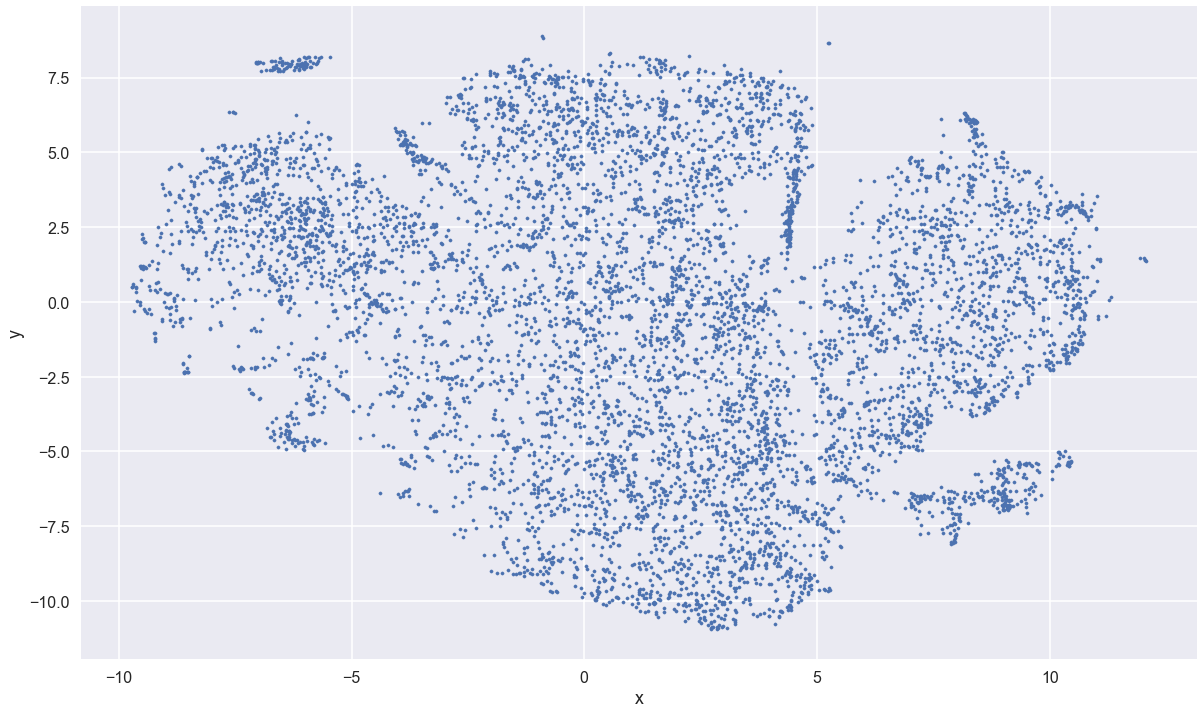

In [30]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

**Zoom in to some interesting places**

In [31]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

**People related to Kingsguard ended up together**

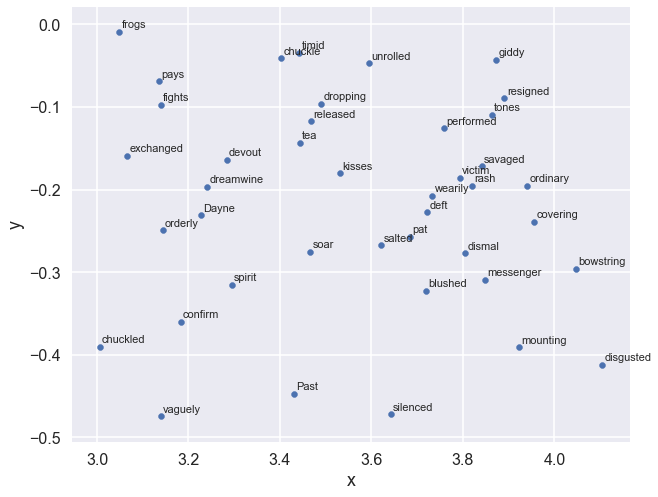

In [34]:
plot_region(x_bounds=(3.0, 4.5), y_bounds=(-0.5, 0.0))

**Food products are grouped nicely as well. Aerys (The Mad King) being close to "roasted" also looks sadly correct**

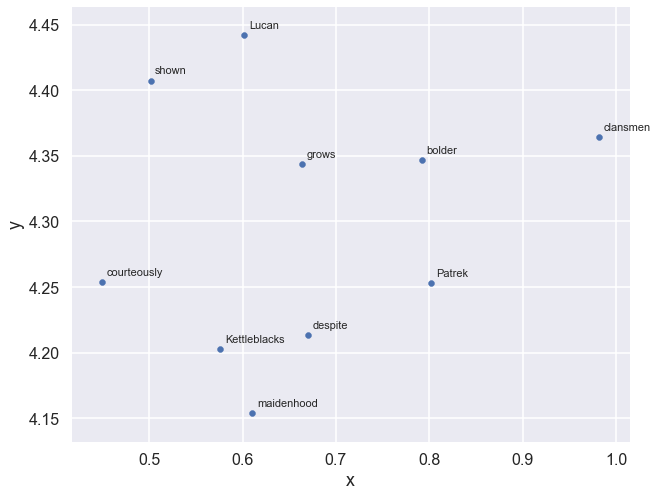

In [35]:
plot_region(x_bounds=(0, 1), y_bounds=(4, 4.5))

### Explore semantic similarities between book characters

**Words closest to the given word**

In [36]:
thrones2vec.most_similar("Stark")

2017-05-10 18:52:12,210 : INFO : precomputing L2-norms of word weight vectors


[('Eddard', 0.9481084942817688),
 ('Robert', 0.938762903213501),
 ('murdered', 0.9319921731948853),
 ('Arryn', 0.9282739758491516),
 ('Brandon', 0.9256768822669983),
 ('Edmure', 0.9247524738311768),
 ('Ned', 0.9227520823478699),
 ('younger', 0.9222394824028015),
 ('Greyjoy', 0.9165821075439453),
 ('North', 0.9154905080795288)]

In [37]:
thrones2vec.most_similar("Aerys")

[('North', 0.9835354089736938),
 ('murdered', 0.9735085964202881),
 ('Dorne', 0.9718100428581238),
 ('Targaryen', 0.9689942598342896),
 ('Sack', 0.9656692147254944),
 ('Dragonstone', 0.961473822593689),
 ('Highgarden', 0.9530640840530396),
 ('Rhaegar', 0.9482442140579224),
 ('Islands', 0.9482008218765259),
 ('Trident', 0.9474884867668152)]

In [38]:
thrones2vec.most_similar("direwolf")

[('greatsword', 0.9352774620056152),
 ('mark', 0.9189867973327637),
 ('favored', 0.9147545099258423),
 ('breach', 0.9142837524414062),
 ('cape', 0.9118398427963257),
 ('officer', 0.9117124080657959),
 ('gaoler', 0.9106044769287109),
 ('cheap', 0.9105573892593384),
 ('Hammer', 0.9097063541412354),
 ('device', 0.9087103605270386)]

**Linear relationships between word pairs**

In [39]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = thrones2vec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [40]:
nearest_similarity_cosmul("Stark", "Winterfell", "Riverrun")
nearest_similarity_cosmul("Jaime", "sword", "wine")
nearest_similarity_cosmul("Arya", "Nymeria", "dragons")

Stark is related to Winterfell, as captive is related to Riverrun
Jaime is related to sword, as Lysa is related to wine
Arya is related to Nymeria, as Weese is related to dragons


'Weese'